In [4]:
from qiskit_aer import AerSimulator, StatevectorSimulator
from qiskit.providers.fake_provider import FakeAlmadenV2, FakeSherbrooke
from qiskit.utils import QuantumInstance
from qiskit.opflow import Gradient, CircuitSampler, StateFn, PauliExpectation
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Estimator, BackendEstimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector

import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import pandas as pd


from Components.train import create_qnn, sampling_experiment, train, train_batch
from Components.data import cancer_data
from Components.circuits import *

from GLOBAL_CONFIG import *

In [5]:
num_qubits = list(range(2, MAX_QUBITS))

G_O = [PauliSumOp.from_list([('Z'*n, 1)]) for n in num_qubits]

# Local operator for all ansatzes, measere 2 qubits

L_O = [PauliSumOp.from_list([('I' * (n - 2)+'Z'*2, 1)]) for n in num_qubits]

In [6]:
# backend = FakeSherbrooke()
# estimator = BackendEstimator(backend)
estimator = Estimator()

In [7]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
Classes:[0 1]; Encoded as: [-1  1]


/Users/ncng/.local/share/virtualenvs/VQA-Notes-v2-orAwPlel/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


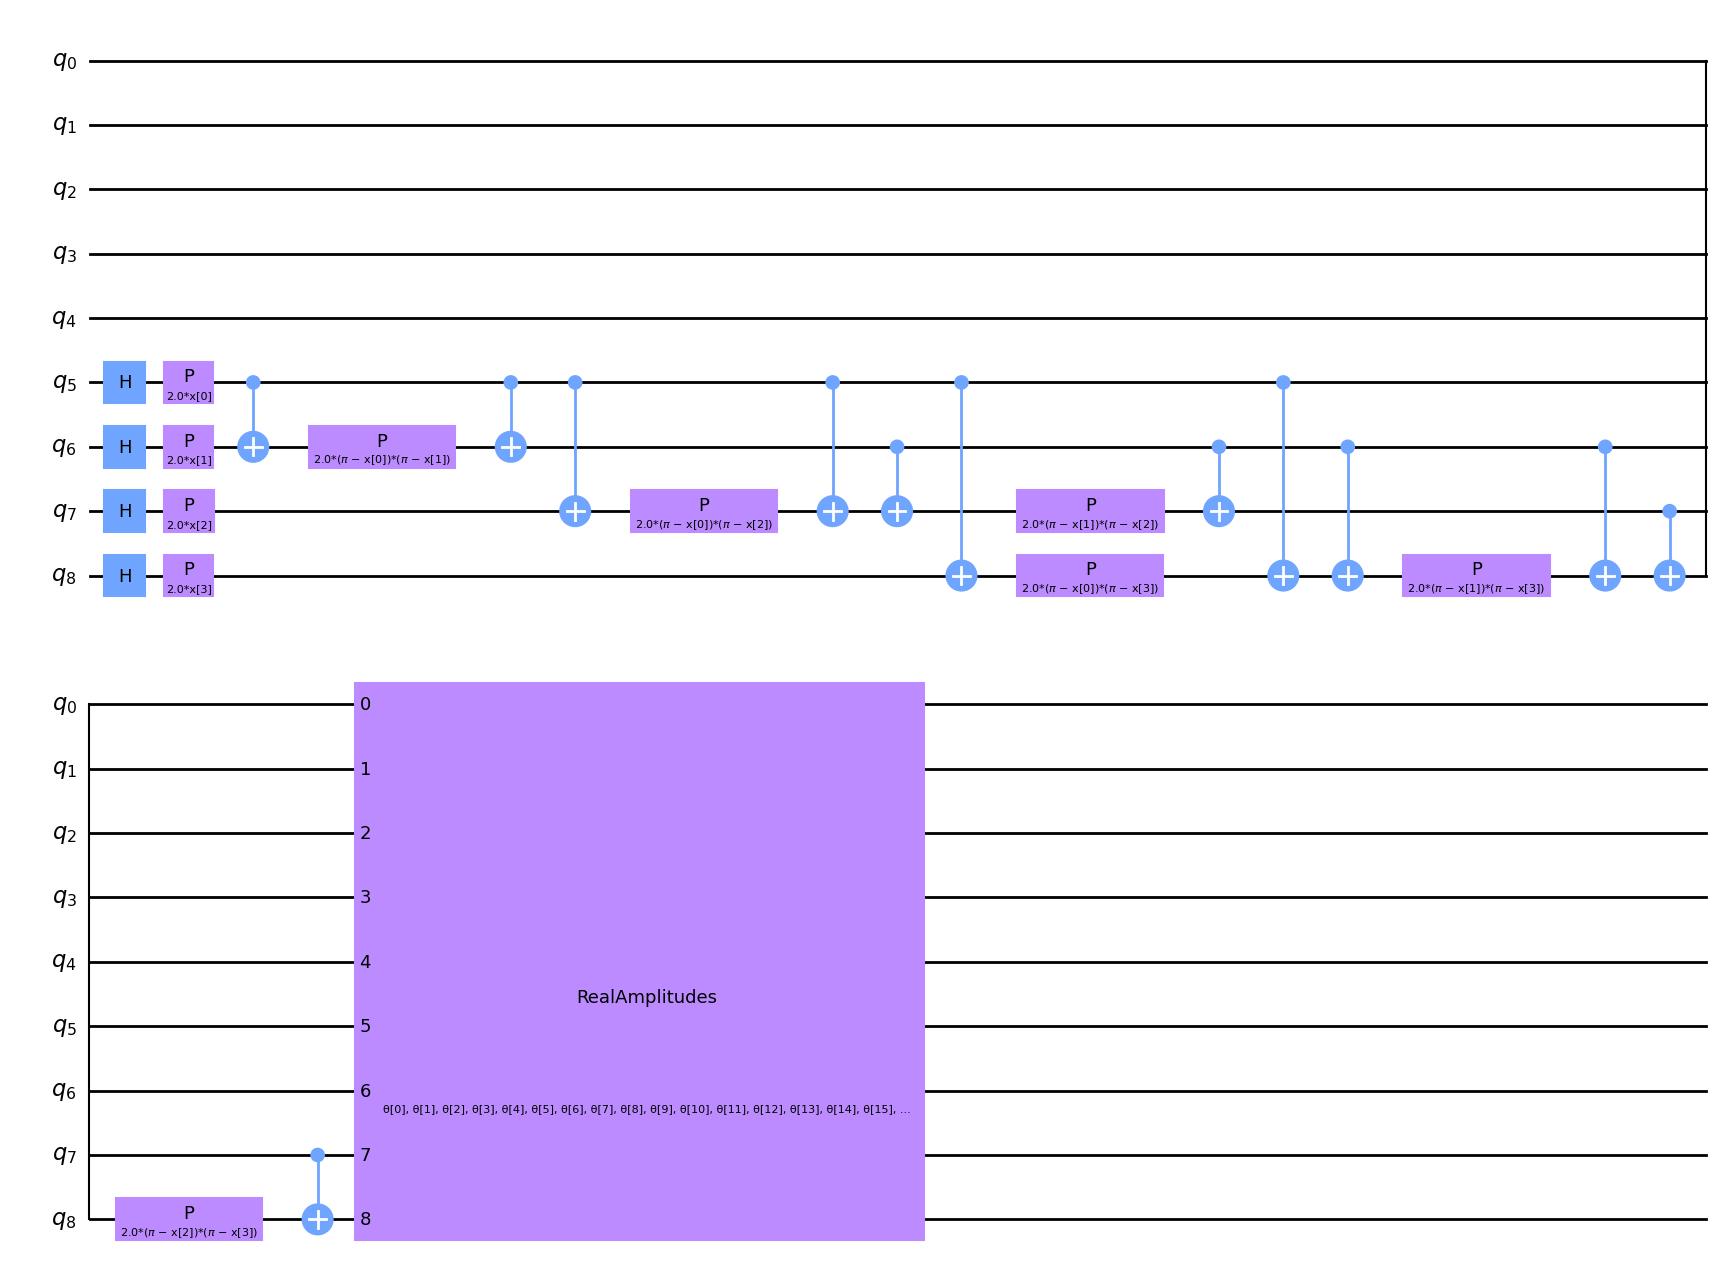

In [8]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(MAX_QUBITS, MAX_REPS, ENTANGLEMENT)

experimental_qc = circuitBuilder(feature_map, ansatz, 'bottom')
experimental_qc.decompose().draw('mpl')

In [9]:
def sampleAnsatz(estimator, ansatzes, operators, ansatzes_parameters=[],):
    ansatzes_to_run = []
    operator_to_run = []
    parameters_to_run = []

    # 100 parameters for ansatzes
    num_values = 100

    # If no parameters are given, create 100 random parameters, or else use the given parameters to scan current gradient
    if len(ansatzes_parameters) == 0:
        for i in range(len(ansatzes)):
            for j in range(num_values):
                ansatzes_to_run.append(ansatzes[i])
                operator_to_run.append(operators[i])
                parameters_to_run.append(np.random.uniform(0, np.pi, ansatzes[i].num_parameters))
    else:
        for i in range(len(ansatzes)):
            for j in range(num_values):
                points = []
                for k in range(ansatzes[i].num_parameters):
                    low = ansatzes_parameters[i][k] - np.pi/2
                    high = ansatzes_parameters[i][k] + np.pi/2
                    points.append(np.random.uniform(low, high))
                parameters_to_run.append(points)
                ansatzes_to_run.append(ansatzes[i])
                operator_to_run.append(operators[i])
    
    # Estimate all ansatzes with provided parameters
    
    job = estimator.run(
        ansatzes_to_run, 
        parameter_values=parameters_to_run, 
        observables=operator_to_run
    )

    job_result = job.result().values

    # Get the expectation values for each ansatz, each 100 entry is one ansatz
    parsed_estimator_result = []
    for i in range(0, len(job_result), num_values):
        parsed_estimator_result.append(job_result[i:i+num_values])
        
    print(f"Number of ansatzes, parameters, operator to run: {len(ansatzes_to_run)}")
    return parsed_estimator_result


def getVariance(data, num_qubits, x_title='Numer of qubits'):
    g=[]
    for d in data:
        g.append(np.gradient(d))

    fit = np.polyfit(num_qubits, np.log(np.var(g, axis=1)), deg=1)
    x = np.linspace(num_qubits[0], num_qubits[-1], 200)

    plt.figure(figsize=(12, 6))
    plt.semilogy(num_qubits, np.var(g, axis=1), 'o-', label='measured variance')
    plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
    plt.xlabel(x_title)
    plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
    plt.legend(loc='best')

    return np.var(g, axis=1)

In [11]:
reps = num_qubits
ansatzes_m0 = [AnsatzGenerator(n, r) for n, r in zip(num_qubits, reps)]
gradients_m0 = sampleAnsatz(estimator, ansatzes_m0, G_O)

Number of ansatzes, parameters, operator to run: 700


array([0.19042517, 0.09020573, 0.09188888, 0.04049843, 0.01848623,
       0.00746074, 0.00456107])

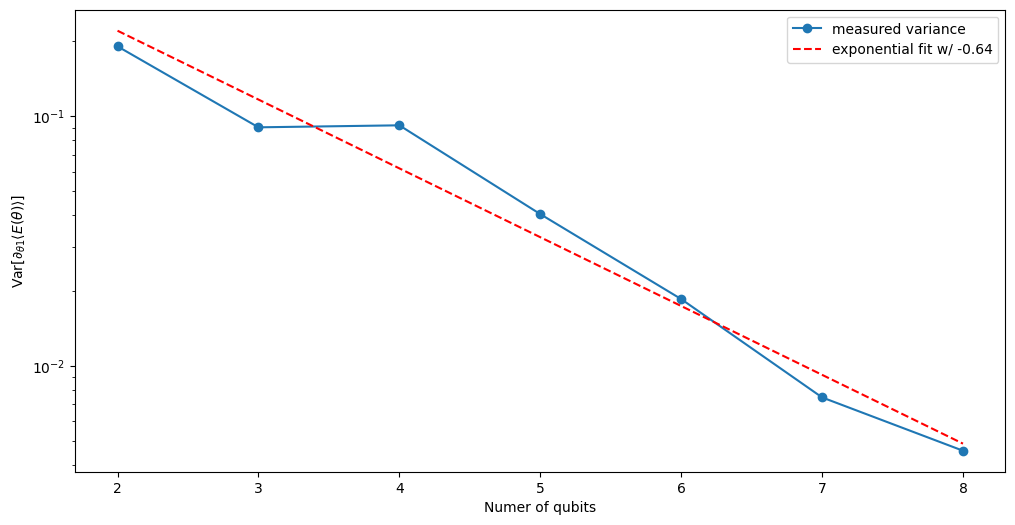

In [12]:
getVariance(gradients_m0, num_qubits)

In [13]:
qnn = EstimatorQNN(
    circuit=experimental_qc,
    estimator=estimator,
    observables=GLOBAL_OPERATOR,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters
)

In [ ]:
model = TorchConnector(qnn)
loss_function = nn.L1Loss() # nn.MSELoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

model, losses, accuracy_train, accuracy_test, weights = train(
    model, 
    10, 
    X_train_t,
    y_train_t,
    X_val_t,
    y_val_t,
    optimizer = optimizer, 
    loss_function = loss_function
)

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)

data = [pd.DataFrame(accuracy_test).astype('float').T]
# Plot data
for i in range(len(data)):
    data[i].T.plot(ax=ax, label=f'inst# {i}', figsize=(5, 3))
ax.legend([f'inst {i}' for i in range(len(data))])
plt.title('instace losses')
plt.show()  